In [1]:
import numpy as np 
import numpy.random as rand
import matplotlib.pyplot as plt
import math
import os
from PIL import Image
from tqdm import tqdm

import torchvision.datasets
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from torch.utils.data import Subset,DataLoader
from torch.optim import Adam

# Forward Process

In [5]:
#Create folders on kaggle to save outputs
os.makedirs('/kaggle/working/models')
os.makedirs('/kaggle/working/models/DDPM1_IMP')
os.makedirs('/kaggle/working/results')
os.makedirs('/kaggle/working/results/DDPM1_IMP')
os.makedirs('/kaggle/working/extras')
os.makedirs('/kaggle/working/extras/DDPM1_IMP')

In [3]:
T=500
IMG_SIZE=32
DEVICE=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def linear_noise_schedule(start=0.0001, end=0.02, steps=T):
    return torch.linspace(start=start, end=end, steps=steps)

def cosine_alpha_cumprod_schedule(end=T,s=0.008):
    t=torch.arange(start=0, end=end, step=1).to(DEVICE)
    return torch.pow(torch.cos((t/T+s)/(1+s)*torch.pi/2),2)

def cosine_noise_schedule(end=T, s = 0.008):
    steps = end + 1
    t = torch.linspace(0, end, steps, dtype = torch.float64) / end
    alphas_cumprod = torch.cos((t + s) / (1 + s) * math.pi * 0.5) ** 2
    alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
    betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
    return torch.clip(betas, 0, 0.999)

cos_betas=cosine_noise_schedule(end=T, s=0.008).to(DEVICE)
cos_alphas=1-cos_betas
cos_alphas_cumprod = torch.cumprod(cos_alphas, dim=0)
sqrt_cos_alphas_cumprod=torch.sqrt(cos_alphas_cumprod)
sqrt_one_minus_cos_alphas_cumprod=torch.sqrt(1-cos_alphas_cumprod)

betas=linear_noise_schedule().to(DEVICE)
alphas=1-betas
alphas_cumprod=torch.cumprod(alphas, dim=0)
sqrt_alphas_cumprod=torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod=torch.sqrt(1-alphas_cumprod)

In [43]:
#Forward diffusion used just for the example, using cosine scheduling
def cos_forward_diffusion_process(x0, t):
    """
    Get noisy image of x0 obtained after t timesteps
    """
    noise=rand.standard_normal(size=x0.shape)
    return sqrt_cos_alphas_cumprod[t].cpu()*x0+sqrt_one_minus_cos_alphas_cumprod[t].cpu()*noise, noise

#Forward diffusion used just for the example, using linear scheduling
def forward_diffusion_process(x0, t):
    """
    Get noisy image of x0 obtained after t timesteps
    """
    noise=rand.standard_normal(size=x0.shape)
    return sqrt_alphas_cumprod[t].cpu()*x0+sqrt_one_minus_alphas_cumprod[t].cpu()*noise, noise

# Can produce noise for multiple images at the same time, used for training with cosine scheduling
def get_noisy_images(x, t):
    noise = torch.randn_like(x)
    return (sqrt_cos_alphas_cumprod[t][:, None, None, None]* x + sqrt_one_minus_cos_alphas_cumprod[t][:, None, None, None] * noise).float(), noise.float()

# Can produce noise for multiple images at the same time, used for training with linear scheduling
def get_noisy_images_linear(x,t):
    noise = torch.randn_like(x)
    return (sqrt_alphas_cumprod[t][:, None, None, None]* x + sqrt_one_minus_alphas_cumprod[t][:, None, None, None] * noise).float(), noise.float()

# Sample a set of t's with size=num
def sample_timesteps(num):
    return torch.tensor(rand.choice(range(T),size=num))

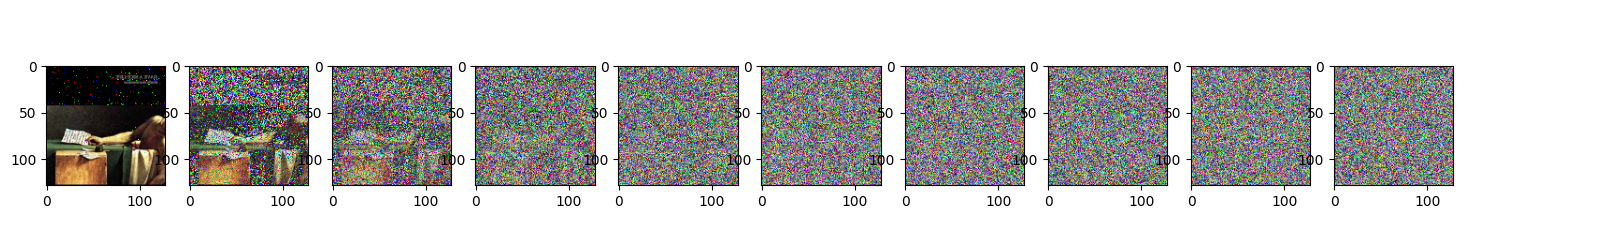

In [48]:
IMG_SIZE=128
# Reduces image resolution
def transform_img(image : Image):
    """
    Horizontal flips given image with random probability
    and scales it to values between -1 and 1.
    """
    image.thumbnail((IMG_SIZE,IMG_SIZE))
    prob=rand.random()

    if prob>0.5:
        image=image.transpose(Image.Transpose.FLIP_LEFT_RIGHT)

    img_arr=np.array(image).astype(np.float32)

    #Scale between -1 and 1
    img_arr=2*img_arr/255-1

    return img_arr

def reverse_transform_img(img_arr):
    """
    Given an image array scales it back to valid RGB
    """
    img_arr=(img_arr+1)/2
    img_arr*=255
    img_arr=np.array(img_arr).astype(np.uint8)
    return img_arr

#Remove this when on kaggle ->

im=Image.open("test_img.jpg")
img=transform_img(im)

# plt.figure(figsize=(20,3))
# plt.axis('off')
# num_images = 10
# stepsize = int(T/num_images)

# for t in range(0, T, stepsize):
#     plt.subplot(1, num_images+1, int(t/stepsize) + 1)
#     noisy_img, noise = cos_forward_diffusion_process(img, t)
#     noisy_img=reverse_transform_img(noisy_img)
#     plt.imshow(noisy_img)

plt.figure(figsize=(20,3))
plt.axis('off')
num_images = 10
stepsize = int(T/num_images)

for t in range(0, T, stepsize):
    plt.subplot(1, num_images+1, int(t/stepsize) + 1)
    noisy_img, noise = forward_diffusion_process(img, t)
    noisy_img=reverse_transform_img(noisy_img)
    plt.imshow(noisy_img)

## Data Loading

In [11]:
IMG_SIZE = 32
BATCH_SIZE = 64

def load_transformed_dataset():
    data_transforms = [
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(), # Scales data into [0,1]
        transforms.Lambda(lambda t: (t * 2) - 1) # Scale between [-1, 1]
    ]
    data_transform = transforms.Compose(data_transforms)

    cifar = torchvision.datasets.CIFAR10(root=".", download=True,
                                         transform=data_transform)
    return cifar

def reverse_transform_tensor(image):
    reverse_transforms = transforms.Compose([
        transforms.Lambda(lambda t: t.clamp(-1,1)),
        transforms.Lambda(lambda t: (t + 1) / 2),
        transforms.Lambda(lambda t: t.permute(1, 2, 0)), # CHW to HWC
        transforms.Lambda(lambda t: t * 255.),
        transforms.Lambda(lambda t: t.numpy().astype(np.uint8)),
        transforms.ToPILImage(),
    ])
    
    return reverse_transforms(image)

data = load_transformed_dataset()

dataloader = DataLoader(data, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

print(data.class_to_idx)

#Dataloader for only 1 class: automobiles
cars = Subset(data, [i for i, (x, y) in enumerate(data) if y == 1])


dataloader_cars = DataLoader(cars, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

#Dataloader for only 5 classes
cifar5 = Subset(data, [i for i, (x, y) in enumerate(data) if y in [0,1,3,7,8]])

dataloader_cifar5 = DataLoader(cifar5, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

Files already downloaded and verified
{'airplane': 0, 'automobile': 1, 'bird': 2, 'cat': 3, 'deer': 4, 'dog': 5, 'frog': 6, 'horse': 7, 'ship': 8, 'truck': 9}


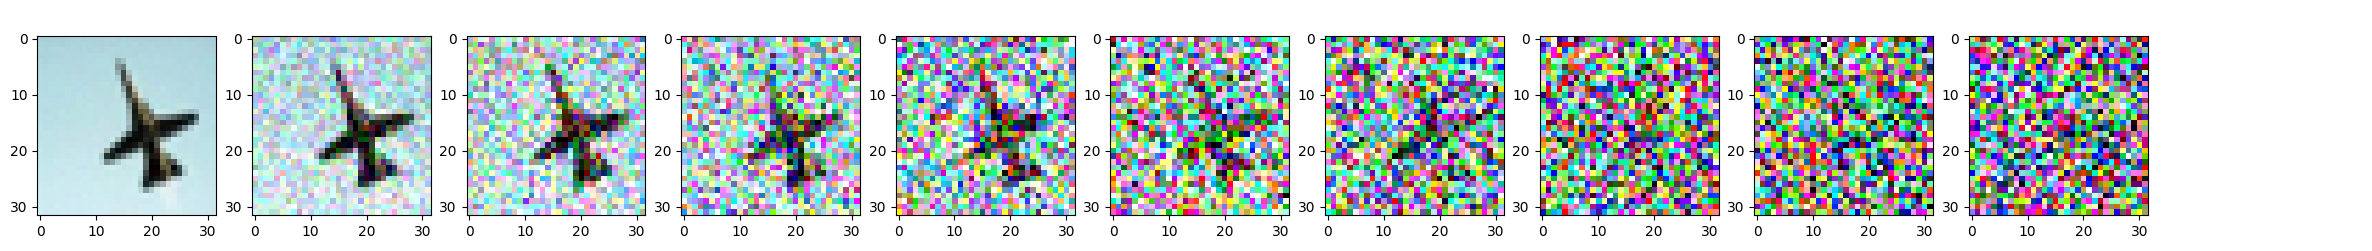

In [81]:
# Simulate forward diffusion
image = next(iter(dataloader_cifar5))[0]

plt.figure(figsize=(30,3))
plt.axis('off')
num_images = 10
stepsize = int(T/num_images)

for idx in range(0, T, stepsize):
    t = torch.Tensor([idx]).type(torch.int64)
    plt.subplot(1, num_images+1, int(idx/stepsize) + 1)

    img, noise = forward_diffusion_process(image, t)

    # Take first image of batch
    if len(img.shape) == 4:
        img = img[0, :, :, :]
    plt.imshow(reverse_transform_tensor(img))

# Backward Process

In [4]:
#Used in the encoder, bottleneck and decoder of the UNet
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None, residual=False):
        super().__init__()
        self.residual = residual
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.GroupNorm(1, mid_channels),
            nn.GELU(),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.GroupNorm(1, out_channels),
        )

    def forward(self, x):
        if self.residual:
            return F.gelu(x + self.double_conv(x))
        else:
            return self.double_conv(x)
        
# Used in the encoder part of the UNet
class DownsampleBlock(nn.Module):
    def __init__(self, in_channels, out_channels, emb_dim=256):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, in_channels, residual=True),
            DoubleConv(in_channels, out_channels),
        )

        self.emb_layer = nn.Sequential(
            nn.SiLU(),
            nn.Linear(
                emb_dim,
                out_channels
            ),
        )

    #Uses positional embeddings
    def forward(self, x, t):
        x = self.maxpool_conv(x)
        emb = self.emb_layer(t)[:, :, None, None].repeat(1, 1, x.shape[-2], x.shape[-1])
        return x + emb

# Used in the decoder part of the UNet
class UpsampleBlock(nn.Module):
    def __init__(self, in_channels, out_channels, emb_dim=256):
        super().__init__()

        self.up = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
        self.conv = nn.Sequential(
            DoubleConv(in_channels, in_channels, residual=True),
            DoubleConv(in_channels, out_channels, in_channels // 2),
        )

        self.emb_layer = nn.Sequential(
            nn.SiLU(),
            nn.Linear(
                emb_dim,
                out_channels
            ),
        )

    #Uses both positional embeddings and skip connections
    def forward(self, x, skip_x, t):
        x = self.up(x)
        x = torch.cat([skip_x, x], dim=1)
        x = self.conv(x)
        emb = self.emb_layer(t)[:, :, None, None].repeat(1, 1, x.shape[-2], x.shape[-1])
        return x + emb

#Self Attention module used troughout the network, after downsample and upsample blocks
class SelfAttention(nn.Module):
    def __init__(self, channels):
        super(SelfAttention, self).__init__()
        self.channels = channels        
        self.mha = nn.MultiheadAttention(channels, 4, batch_first=True)
        self.ln = nn.LayerNorm([channels])
        self.ff_self = nn.Sequential(
            nn.LayerNorm([channels]),
            nn.Linear(channels, channels),
            nn.GELU(),
            nn.Linear(channels, channels),
        )

    def forward(self, x):
        size = x.shape[-1]
        x = x.view(-1, self.channels, size * size).swapaxes(1, 2)
        x_ln = self.ln(x)
        attention_value, _ = self.mha(x_ln, x_ln, x_ln)
        attention_value = attention_value + x
        attention_value = self.ff_self(attention_value) + attention_value
        return attention_value.swapaxes(2, 1).view(-1, self.channels, size, size)

class ImprovedSimplifiedUNet(nn.Module):
    def __init__(self, c_in=3, c_out=3, n_classes=None, time_emb_dim=256):
        super().__init__()
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.time_emb_dim = time_emb_dim
        self.start_dconv = DoubleConv(c_in, 64)
        self.downsample1 = DownsampleBlock(64, 128)
        self.sattention1 = SelfAttention(128)
        self.downsample2 = DownsampleBlock(128, 256)
        self.sattention2 = SelfAttention(256)
        self.downsample3 = DownsampleBlock(256, 256)
        self.sattention3 = SelfAttention(256)

        self.bottleneck_dconv1 = DoubleConv(256, 512)
        self.bottleneck_dconv2 = DoubleConv(512, 512)
        self.bottleneck_dconv3 = DoubleConv(512, 256)

        self.upsample1 = UpsampleBlock(512, 128)
        self.sattention4 = SelfAttention(128)
        self.upsample2 = UpsampleBlock(256, 64)
        self.sattention5 = SelfAttention(64)
        self.upsample3 = UpsampleBlock(128, 64)
        self.sattention6 = SelfAttention(64)
        self.end_conv = nn.Conv2d(64, c_out, kernel_size=1)

        # Used for class guidance
        if n_classes != None:
            self.class_embedding=nn.Embedding(n_classes, time_emb_dim)

    def pos_encoding(self, t, channels):
        """
        Adapted positional encoding implementation from PyTorch docs
        """
        div_term = torch.exp(torch.arange(0, channels, 2) * (-math.log(10000.0) / channels)).to(self.device)
        pos_enc = torch.zeros(t.shape[0], channels, device=self.device)
        pos_enc[:, 0::2] = torch.sin(t * div_term)
        pos_enc[:, 1::2] = torch.cos(t * div_term)
        
        return pos_enc

    def forward(self, x, t, y):

        # Time Positional Embedding
        t = t.unsqueeze(-1).type(torch.float)
        t = self.pos_encoding(t, self.time_emb_dim)[:x.size(0)]
        
        # Class guidance
        if y!=None:
            t+=self.class_embedding(y)

        # Encoder
        x1 = self.start_dconv(x)
        x2 = self.downsample1(x1, t)
        x2 = self.sattention1(x2)
        x3 = self.downsample2(x2, t)
        x3 = self.sattention2(x3)
        x4 = self.downsample3(x3, t)
        x4 = self.sattention3(x4)

        # Bottleneck
        x4 = self.bottleneck_dconv1(x4)
        x4 = self.bottleneck_dconv2(x4)
        x4 = self.bottleneck_dconv3(x4)

        # Decoder
        x = self.upsample1(x4, x3, t)
        x = self.sattention4(x)
        x = self.upsample2(x, x2, t)
        x = self.sattention5(x)
        x = self.upsample3(x, x1, t)
        x = self.sattention6(x)
        output = self.end_conv(x)
        return output
    
model = ImprovedSimplifiedUNet(c_in=3, c_out=3)
print("Num params: ", sum(p.numel() for p in model.parameters()))

Num params:  23332739


In [40]:
def sample(model, n, guidance_level=0.7, class_samples=None, n_classes=10):
    """
    Implementation of the algorithm 2 of the paper (Sampling algorithm)
    """
    print(f"Sampling {n} new images")

    plt.figure(figsize=(20,3))
    plt.axis('off')
    num_images = 10
    stepsize = int(T/num_images)

    t_list=list(range(1,T,stepsize))

    model.eval()
    with torch.no_grad():
        # Creates random noise image
        x = torch.randn((n, 3, IMG_SIZE, IMG_SIZE)).to(DEVICE)
        if class_samples is None:
            if n_classes==1:
                #Cars belong to class 1, generate labels corresponding to cars observations
                class_samples = torch.ones(n).int().to(DEVICE)
            elif n_classes==5:
                #Generate labels belonging to the set of previously chosen classes 
                possible_classes=torch.tensor([0,1,3,7,8])
                indexes=torch.randint(0,n_classes, (n,))
                class_samples=possible_classes[indexes].int().to(DEVICE)
            print(class_samples)
        for i in list(range(1,T))[::-1]:
            t=(torch.ones(n) * i).long().to(DEVICE)

            # Predicts noise at timestep t for all noisy images in x
            predicted_noise=model(x,t,class_samples)
            predicted_noise_wout_cfg=model(x,t,None)

            #Interpolates between predicted noise obtained without information from classes and with classes 
            final_predicted_noise = torch.lerp(predicted_noise_wout_cfg, predicted_noise, guidance_level)

            alpha=alphas[t][:, None, None, None] 
            alpha_cumprod=alphas_cumprod[t][:, None, None, None]
            beta=betas[t][:, None, None, None]

            if i>1:
                noise=torch.randn_like(x)
            else:
                noise=torch.zeros_like(x)

            # Removing noise from the image
            x = (1 / torch.sqrt(alpha) * (x - ((1 - alpha) / (torch.sqrt(1 - alpha_cumprod))) * final_predicted_noise) + torch.sqrt(beta) * noise).float()
            
            #x=x.clamp(-1,1)

            #Backward process figure
            if i in t_list:
                if len(x.shape) == 4:
                    img = x[0, :, :, :].cpu()
                plt.subplot(1, num_images+1, int(i/stepsize) + 1)
                new_img=reverse_transform_tensor(img)
                plt.imshow(new_img)

    plt.show()
    model.train()
    # Transform to deafult color intensity values
    x=(x.clamp(-1,1)+1)/2
    x=(x*255).type(torch.uint8)
    return x

In [6]:
def save_images(images, path, **kwargs):
    grid = torchvision.utils.make_grid(images, **kwargs)
    ndarr = grid.permute(1, 2, 0).to('cpu').numpy()
    im = Image.fromarray(ndarr)
    im.save(path)

In [7]:
def train(epochs, dataloader, lr=0.001, device='cuda', name='DDPM1', qSample=True, n_classes=5):
    model = ImprovedSimplifiedUNet(n_classes=10).to(device)
    optimizer = Adam(model.parameters(), lr=lr)
    mse = nn.MSELoss()
    losses=[]
    epoch_times=[]
    for epoch in range(epochs):
        print(f"Starting epoch {epoch}:")
        pbar = tqdm(dataloader)
        for i, (images, classes) in enumerate(pbar):
            images = images.to(device)
            classes=classes.to(device)

            t = sample_timesteps(len(images)).to(device)
            x_t, noise = get_noisy_images_linear(images, t)

            #10% of the batches will train without CFG (Unconditionally)
            if np.random.random()<0.1:
                classes=None
                
            predicted_noise = model(x_t, t, classes)
            loss = mse(noise, predicted_noise)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            losses.append(loss.item())
            pbar.set_postfix(MSE=loss.item())

            if i==len(pbar)-1:
                epoch_times.append(pbar.format_dict["elapsed"])
            
        print(f"Epoch {epoch} | Loss: {loss.item()} ")
        if qSample or (epoch+1)%50==0 or epoch==0:
            sampled_images = sample(model, n=64, guidance_level=0.7, class_samples=None, n_classes=n_classes)
            save_images(sampled_images, os.path.join("results", name, f"{epoch+1}.jpg"))
            torch.save(model.state_dict(), os.path.join("models", name, f"checkpoint{epoch+1}.pt"))
            np.save(os.path.join("extras", name, f"losses.npy"), np.array(losses))
            np.save(os.path.join("extras", name, f"epoch_times.npy"), np.array(epoch_times))

In [15]:
train(500, dataloader_cars, qSample=False, name="DDPM1_IMP", n_classes=1)